In [261]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from os.path import exists, join
import os
import xarray as xr
import pandas as pd
from glob import glob
import sys
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib.colors import LogNorm
from IPython.display import Image
from hagelslag.evaluation.ProbabilityMetrics import DistributedROC, DistributedReliability
from hagelslag.evaluation.MetricPlotter import roc_curve, performance_diagram, attributes_diagram
from keras.models import Sequential, Model
from keras.layers import Conv2D, Conv2DTranspose, Flatten, Dense, Input, Conv1D
from keras.layers import Activation, Reshape, LeakyReLU, concatenate, Dropout, BatchNormalization
from keras.regularizers import l2
from keras.optimizers import Adam
import pickle
os.environ["CUDA_VISIBLE_DEVICES"] = "6"


# Data Loading
Load storm patch data from every file.

In [3]:
def load_storm_patch_data(data_path, variable_names):
    data_patches = []
    centers = []
    valid_dates = []
    data_files = sorted(glob(join(data_path, "*.nc")))
    for data_file in data_files:
        print(data_file)
        ds = xr.open_dataset(data_file)
        patch_arr = []
        all_vars = list(ds.variables.keys())
        if np.all(np.in1d(variable_names, all_vars)):
            centers.append(np.array([ds["longitude"][:, 32, 32], ds["latitude"][:, 32, 32]]).T)
            valid_dates.append(ds["valid_date"].values)
            for variable in variable_names:
                patch_arr.append(ds[variable].values)
            data_patches.append(np.stack(patch_arr, axis=-1))
        ds.close()
    center_arr = np.vstack(centers)
    valid_date_index = pd.DatetimeIndex(np.concatenate(valid_dates))
    data = np.vstack(data_patches)
    return data, center_arr, valid_date_index

In [5]:
data = xr.open_dataset("/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016052600_mem_09.nc")

In [7]:
all_vars = list(data.variables.keys())
variable_names = ['composite_reflectivity_entire_atmosphere_current',
                  'precipitable_water_entire_atmosphere_(considered_as_a_single_layer)_current',
                  'geopotential_height_level_of_adiabatic_condensation_from_sfc_prev',
                  'convective_available_potential_energy_180-0_mb_above_ground_prev',
                  'vertical_u-component_shear_0-6000_m_above_ground_prev',
                  'vertical_v-component_shear_0-6000_m_above_ground_prev',
                  ]
np.all(np.in1d(variable_names, all_vars))

True

In [8]:
storm_data, storm_centers, storm_dates = load_storm_patch_data("/scratch/dgagne/ncar_ens_storm_patches/", variable_names)

/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_02.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_03.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_04.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_05.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_06.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_07.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_08.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_09.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050300_mem_10.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_01.nc
/scratch/dgagne/ncar_ens_storm_patches/ncar_ens_storm_patches_2016050400_mem_02.nc
/scr

In [9]:
storm_reports = pd.read_csv("http://www.spc.noaa.gov/wcm/data/2016_hail.csv", parse_dates={"datetime":["date", "time"]})
severe_reports = storm_reports.loc[storm_reports["mag"] >= 1]
severe_reports = severe_reports.reset_index()

In [36]:
severe_reports.columns

Index(['datetime', 'om', 'yr', 'mo', 'dy', 'tz', 'st', 'stf', 'stn', 'mag',
       'inj', 'fat', 'loss', 'closs', 'slat', 'slon', 'elat', 'elon', 'len',
       'wid', 'ns', 'sn', 'sg', 'f1', 'f2', 'f3', 'f4'],
      dtype='object')

In [10]:
def gc_distance(lon_1, lat_1, lon_2, lat_2):
    inv_lat_1 = np.radians(90 - lat_1)
    inv_lat_2 = np.radians(90 - lat_2)
    lon_1_rad = np.radians(lon_1)
    lon_2_rad = np.radians(lon_2)
    radius = 6373.0
    arc = np.arccos(np.sin(inv_lat_1) * np.sin(inv_lat_2) * np.cos(lon_1_rad - lon_2_rad) + np.cos(inv_lat_1) * np.cos(inv_lat_2))
    return radius * arc

In [11]:
severe_reports.shape

(7269, 28)

In [12]:
tdiff = pd.TimedeltaIndex(np.abs(severe_reports["datetime"].values - np.datetime64(storm_dates[0])))
tdiff.total_seconds() / 3600

array([ 2779.05      ,  2779.        ,  2779.        , ...,  5739.36666667,
        5740.41666667,  5740.65      ])

In [13]:
has_severe_hail = np.zeros(storm_dates.size)
min_severe_hail_distance = np.ones(storm_dates.size) * np.nan
min_times = np.ones(storm_dates.size)
for s in range(has_severe_hail.size):
    tdiff = pd.TimedeltaIndex(np.abs(severe_reports["datetime"].values - np.datetime64(storm_dates.values[s])))
    valid_times = np.where((tdiff.total_seconds() / 3600) < 3)[0]
    min_times[s] = (tdiff.total_seconds() / 3600).min()
    if len(valid_times) > 0:
        has_severe_hail[s] = np.count_nonzero(gc_distance(storm_centers[s, 0], 
                                                      storm_centers[s, 1], 
                                                      severe_reports.loc[valid_times, "slon"], 
                                                      severe_reports.loc[valid_times, "slat"]) < 40)
        min_severe_hail_distance[s] = gc_distance(storm_centers[s, 0], 
                                                   storm_centers[s, 1], 
                                                   severe_reports.loc[valid_times, "slon"], 
                                                   severe_reports.loc[valid_times, "slat"]).min()

In [20]:
np.nanpercentile(min_severe_hail_distance, [10, 25, 50, 75, 90])

array([   95.97489924,   193.48882759,   399.14211906,   843.57958968,
        1384.59445067])

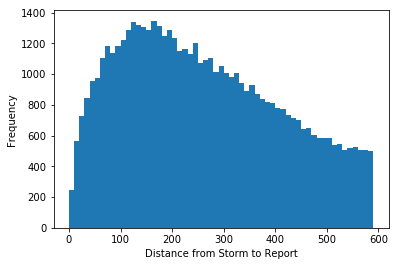

In [21]:
plt.hist(min_severe_hail_distance[~np.isnan(min_severe_hail_distance)], 
         bins=np.arange(0, 600, 10), cumulative=False)
plt.xlabel("Distance from Storm to Report")
plt.ylabel("Frequency")

(array([ 62031.,  12714.,  10564.,   8643.,   7649.,   5215.,   2950.,
          1658.,   1225.,    463.]),
 array([  0.        ,   1.05833333,   2.11666667,   3.175     ,
          4.23333333,   5.29166667,   6.35      ,   7.40833333,
          8.46666667,   9.525     ,  10.58333333]),
 <a list of 10 Patch objects>)

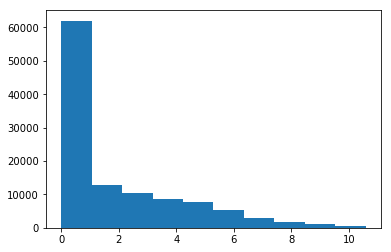

In [22]:
plt.hist(min_times)

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/numpy/lib/function_base.py:804: RuntimeWarning: invalid value encountered in greater_equal
  not_smaller_than_edge = (sample[:, i] >= edges[i][-1])


/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/colors.py:927: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


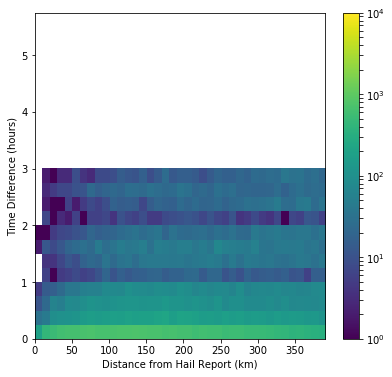

In [26]:
plt.figure(figsize=(6.5, 6))
plt.hist2d(min_severe_hail_distance, min_times, 
           bins=[np.arange(0, 400, 10), np.arange(0, 6, 0.25)], 
           norm=LogNorm(vmin=1, vmax=10000),cmin=1)
plt.colorbar()
plt.gca().set(xlabel="Distance from Hail Report (km)", ylabel="Time Difference (hours)")

In [157]:
np.nanpercentile(min_severe_hail_distance, 10)

81.685311658436007

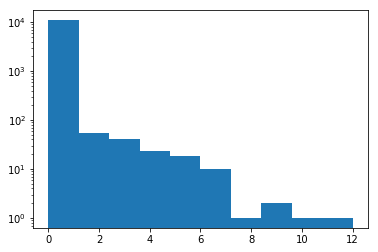

In [158]:
plt.hist(has_severe_hail)
plt.gca().set_yscale("log")

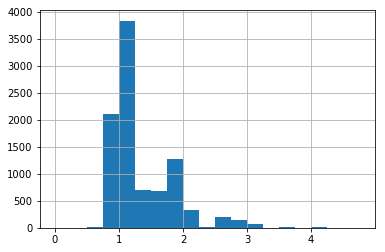

In [32]:
storm_reports["mag"].hist(bins=np.arange(0, 5, 0.25))

(array([ 12008057.,   3733178.,   5540028.,   6935915.,   6556225.,
          6588118.,   2745624.,    878621.,    228162.,     18200.]),
 array([-20.     ,  -9.75625,   0.4875 ,  10.73125,  20.975  ,  31.21875,
         41.4625 ,  51.70625,  61.95   ,  72.19375,  82.4375 ]),
 <a list of 10 Patch objects>)

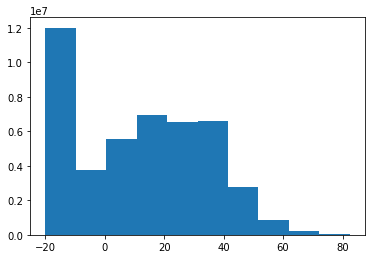

In [106]:
plt.hist(storm_data[:, :, :, 0].ravel())

In [32]:
storm_data[:, :, :, 4].mean()

3.8873699

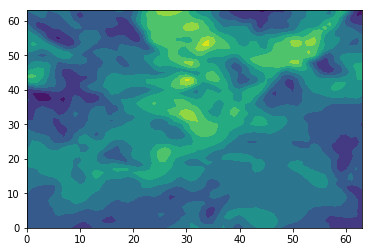

In [83]:
plt.contourf(storm_data[355, :, :, 1])

In [74]:
cape_sqrt = np.sqrt(storm_data[:, :, :, 2].reshape(storm_data.shape[0], 64 * 64))


In [75]:
pc = PCA(n_components=10)
pc.fit((cape_sqrt - cape_sqrt.mean()) / cape_sqrt.std())

PCA(copy=True, iterated_power='auto', n_components=10, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

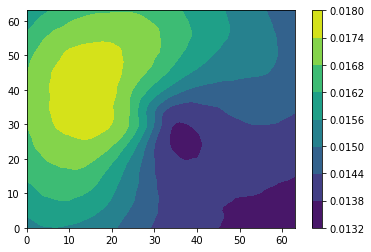

In [78]:
plt.contourf(pc_objs[2].components_[0].reshape(64,64))
plt.colorbar()

In [28]:
unique_storm_dates = np.unique(storm_dates.date)
shuffled_storm_dates = np.random.permutation(unique_storm_dates)
split_point = int(0.7 * len(shuffled_storm_dates))
train_dates = np.sort(shuffled_storm_dates[:split_point])
test_dates = np.sort(shuffled_storm_dates[split_point:])
train_indices = np.where(np.in1d(storm_dates.date, train_dates))[0]
test_indices = np.where(np.in1d(storm_dates.date, test_dates))[0]

In [46]:
pc_objs = []
means = []
sds = []
num_comps = 10
num_vars = 6
pc_train_data = np.zeros((train_indices.size, num_comps * num_vars))
pc_test_data = np.zeros((test_indices.size, num_comps * num_vars))
for v in range(num_vars):
    print(v)
    pc_objs.append(PCA(n_components=10))
    var_data = storm_data[:, :, :, v].reshape(-1, 64 * 64)
    means.append(var_data.mean())
    sds.append(var_data.std())
    norm_data = (var_data - means[v]) / sds[v]
    pc_train_data[:, v * 10: (v + 1) * 10] = pc_objs[v].fit_transform(norm_data[train_indices])
    pc_test_data[:, v * 10: (v + 1) * 10] = pc_objs[v].transform(norm_data[test_indices])

0
1
2
3
4
5


In [264]:
for p, pc_obj in enumerate(pc_objs):
    with open("/scratch/dgagne/hail_models/pc_obj_{0:d}.pkl".format(p), "wb") as pc_file:
        pickle.dump(pc_obj, pc_file, protocol=pickle.HIGHEST_PROTOCOL)

(array([  8.40000000e+01,   4.02000000e+02,   2.82400000e+03,
          4.32840000e+04,   3.86942800e+06,   2.65179470e+07,
          2.74679710e+07,   3.54791740e+07,   4.25210630e+07,
          4.77017180e+07,   5.11830660e+07,   5.36286590e+07,
          5.30860510e+07,   4.49446320e+07,   3.22885810e+07,
          2.24033460e+07,   1.41050390e+07,   6.10807300e+06,
          1.80974900e+06,   1.45661000e+05]),
 array([ 3.7516489 ,  3.99670758,  4.24176626,  4.48682494,  4.73188362,
         4.9769423 ,  5.22200098,  5.46705966,  5.71211834,  5.95717702,
         6.2022357 ,  6.44729438,  6.69235306,  6.93741174,  7.18247042,
         7.4275291 ,  7.67258778,  7.91764646,  8.16270514,  8.40776381,
         8.65282249]),
 <a list of 20 Patch objects>)

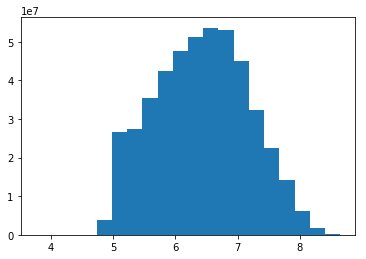

In [47]:
plt.hist(np.log(storm_data[:, :, :, 2].ravel()), bins=20)

In [49]:
short_var_names = ["Reflectivity", "Precipitable Water", "LCL Height", "CAPE", "0-6 km Shear-U", "0-6 km Shear-V"]

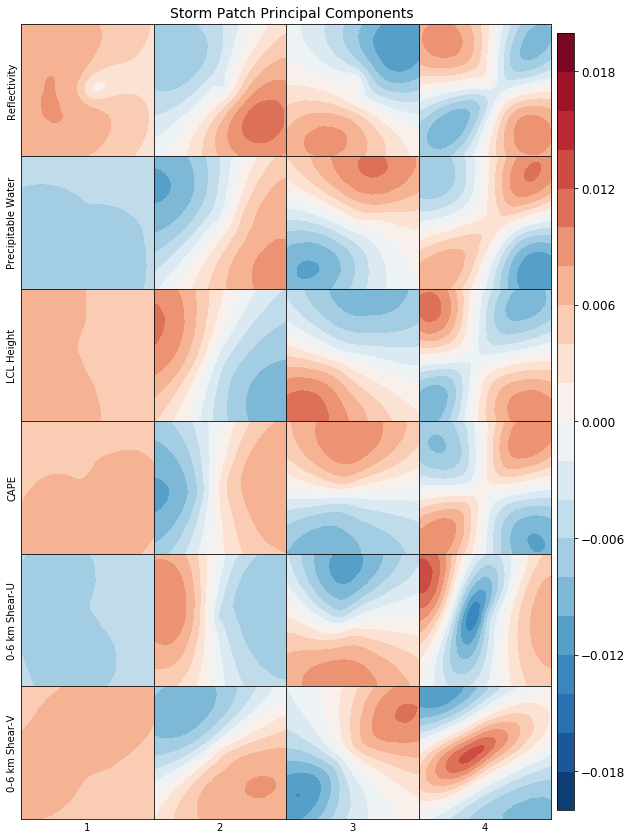

In [90]:
vis_comps = 4
fig, axes = plt.subplots(num_vars, vis_comps, figsize=(8, 12))
plt.subplots_adjust(0.03, 0.03, 0.95, 0.95, wspace=0, hspace=0)
cax = fig.add_axes([0.96, 0.04, 0.03, 0.9])
p_ex = np.round(np.max([np.maximum(np.abs(pc_obj.components_.min()), 
                                  pc_obj.components_.max()) for pc_obj in pc_objs]),3)
for p, pc_obj in enumerate(pc_objs):
    for v in range(vis_comps):
        axes[p, v].contourf(pc_obj.components_[v].reshape(64, 64), np.linspace(-p_ex, p_ex, 21), cmap="RdBu_r")
        axes[p, v].axes.get_xaxis().set_ticks([])
        axes[p, v].axes.get_yaxis().set_ticks([])
        axes[-1, v].set(xlabel=v + 1)
    axes[p, 0].set(ylabel=short_var_names[p])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=12)
fig.suptitle("Storm Patch Principal Components", y=0.97, fontsize=14)
plt.savefig("storm_patch_pca.png", dpi=250, bbox_inches="tight")

In [57]:
mv_means = []
mv_sds = []
mv_num_comps = 15
mv_num_vars = 6
mv_pc_obj = PCA(n_components=mv_num_comps)
mv_pc_train_data = np.zeros((train_indices.size, mv_num_comps))
mv_pc_test_data = np.zeros((test_indices.size, mv_num_comps))
mv_norm_data = np.zeros((storm_data.shape[0], 64 * 64 * num_vars))
for v in range(mv_num_vars):
    print(v)
    #if v == 2:
    #    var_data = np.sqrt(storm_data[:, :, :, v].reshape(-1, 64 * 64))
    #else:
    var_data = storm_data[:, :, :, v].reshape(-1, 64 * 64)
    mv_means.append(var_data.mean())
    mv_sds.append(var_data.std())
    mv_norm_data[:, 64 * 64 * v: 64 * 64 * (v + 1)] = (var_data - means[v]) / sds[v]
mv_pc_train_data[:, :] = mv_pc_obj.fit_transform(mv_norm_data[train_indices])
mv_pc_test_data[:, :] = mv_pc_obj.transform(mv_norm_data[test_indices])

0
1
2
3
4
5


In [60]:
mv_pc_obj.components_[0, 0:4096]

array([-0.00144565, -0.00145403, -0.00144767, ..., -0.00298122,
       -0.00299205, -0.00300172])

0.02


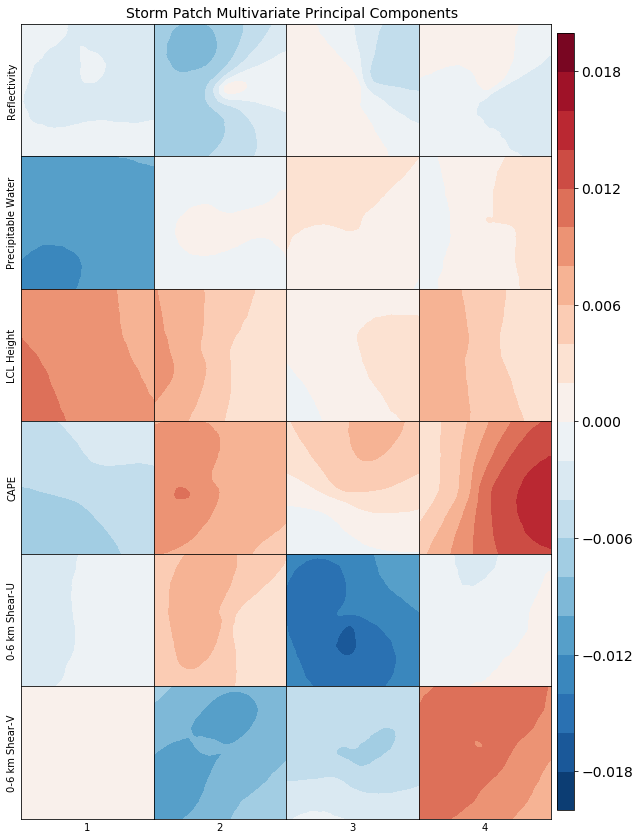

In [81]:
vis_comps = 4
fig, axes = plt.subplots(num_vars, vis_comps, figsize=(8, 12))
plt.subplots_adjust(0.03, 0.03, 0.95, 0.95, wspace=0, hspace=0)
p_ex = np.round(np.maximum(np.abs(mv_pc_obj.components_.min()), np.abs(mv_pc_obj.components_.max())), decimals=2)
print(p_ex)
cax = fig.add_axes([0.96, 0.04, 0.03, 0.9])
for p in range(mv_num_vars):
    for v in range(vis_comps):
        cont = axes[p, v].contourf(mv_pc_obj.components_[v, 4096 * p: 4096 * (p + 1)].reshape(64, 64), 
                                   np.linspace(-np.round(p_ex,2), np.round(p_ex, 2), 21), cmap="RdBu_r")
        axes[p, v].axes.get_xaxis().set_ticks([])
        axes[p, v].axes.get_yaxis().set_ticks([])
        axes[-1, v].set(xlabel=v + 1)
    axes[p, 0].set(ylabel=short_var_names[p])
cbar = fig.colorbar(cont, cax=cax)
cbar.ax.tick_params(labelsize=14)
fig.suptitle("Storm Patch Multivariate Principal Components", y=0.97, fontsize=14)
plt.savefig("storm_patch_mv_pca.png", dpi=250, bbox_inches="tight")

In [265]:
with open("/scratch/dgagne/hail_models/mv_pc_obj.pkl", "wb") as mv_pc_file:
    pickle.dump(mv_pc_obj, mv_pc_file, protocol=pickle.HIGHEST_PROTOCOL)

In [80]:
mv_pc_obj.explained_variance_ratio_.cumsum()

array([ 0.26224319,  0.39715266,  0.5017871 ,  0.56405734,  0.60845819,
        0.64313243,  0.66565697,  0.68609429,  0.70413863,  0.71985591,
        0.73287605,  0.74418798,  0.75529596,  0.76443923,  0.77227881])

In [91]:
min_severe_hail_distance[np.isnan(min_severe_hail_distance)] = 9999999
train_labels = np.where(min_severe_hail_distance[train_indices] < 160, 1, 0)
test_labels = np.where(min_severe_hail_distance[test_indices] < 160, 1, 0)

In [92]:
rf_mv = RandomForestClassifier(n_estimators=500, n_jobs=4, max_features="sqrt")
rf_mv.fit(mv_pc_train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [95]:
rf_mv.feature_importances_

array([ 0.08324431,  0.08501885,  0.07196579,  0.10570814,  0.06745616,
        0.06930211,  0.0582372 ,  0.05980636,  0.06031243,  0.05656393,
        0.05418257,  0.05830467,  0.05808239,  0.05618861,  0.0556265 ])

In [97]:
rf_mv_preds = rf_mv.predict_proba(mv_pc_test_data)[:, 1]

In [96]:
rf = RandomForestClassifier(n_estimators=500, n_jobs=4, max_features="sqrt")
rf.fit(pc_train_data, train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=500, n_jobs=4, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [98]:
rf_preds = rf.predict_proba(pc_test_data)[:, 1]

In [266]:
pickle.dump(rf, open("/scratch/dgagne/hail_models/hail_rf.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(rf_mv, open("/scratch/dgagne/hail_models/hail_rf_mv.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(logit, open("/scratch/dgagne/hail_models/hail_logit.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)
pickle.dump(logit_mv, open("/scratch/dgagne/hail_models/hail_logit_mv.pkl", "wb"), protocol=pickle.HIGHEST_PROTOCOL)

(array([  7.46700000e+03,   8.47100000e+03,   6.78700000e+03,
          5.17700000e+03,   3.29800000e+03,   1.71600000e+03,
          6.64000000e+02,   2.07000000e+02,   4.90000000e+01,
          6.00000000e+00]),
 array([ 0.    ,  0.0706,  0.1412,  0.2118,  0.2824,  0.353 ,  0.4236,
         0.4942,  0.5648,  0.6354,  0.706 ]),
 <a list of 10 Patch objects>)

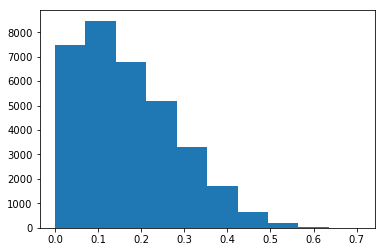

In [100]:
plt.hist(rf_preds)

In [114]:
logit_mv = LogisticRegression(penalty="l1")
logit_mv.fit(mv_pc_train_data, train_labels)
logit_mv_preds = logit_mv.predict_proba(mv_pc_test_data)[:, 1]

In [101]:
logit = LogisticRegression(penalty="l1")
logit.fit(pc_train_data, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [102]:
logit_preds = logit.predict_proba(pc_test_data)[:, 1]

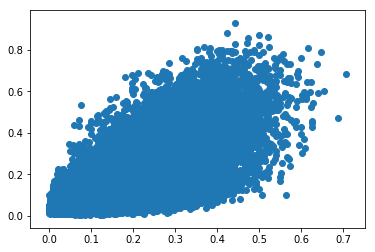

In [202]:
plt.scatter(rf_preds, logit_preds)

In [34]:
logit.coef_

array([[ 0.00410254, -0.00206951, -0.00654126,  0.00235539, -0.00701154,
         0.00216319, -0.00476771,  0.00142651,  0.00610242, -0.00016836,
         0.01656552,  0.02712975,  0.00357492,  0.0206493 ,  0.02383388,
        -0.01684514, -0.00341637,  0.0062114 , -0.00365573, -0.00946042,
         0.01847374, -0.00182606,  0.00297849,  0.00362054, -0.01020593,
         0.01486102, -0.00443039, -0.00279718, -0.00404756,  0.00174898,
        -0.00894072,  0.00694267,  0.00787597, -0.00852641, -0.00061422,
         0.00285988,  0.00311282,  0.00044144,  0.00055422,  0.00997964,
         0.0040147 ,  0.0025486 ,  0.00763022, -0.00820168,  0.01043601,
         0.00249809,  0.00232485, -0.00380224, -0.0044822 , -0.00505782]])

In [219]:
thresholds = np.linspace(0, 1, 30)
rf_roc = DistributedROC(thresholds=thresholds)
rf_roc.update(rf_preds, test_labels)
rv_mv_roc = DistributedROC(thresholds=thresholds)
rv_mv_roc.update(rf_mv_preds, test_labels)
logit_roc = DistributedROC(thresholds=thresholds)
logit_roc.update(logit_preds, test_labels)
logit_mv_roc = DistributedROC(thresholds=thresholds)
logit_mv_roc.update(logit_mv_preds, test_labels)
cnn_roc = DistributedROC(thresholds=thresholds)
cnn_roc.update(cnn_preds[:, 0], test_labels)
print(rf_roc.auc(), rv_mv_roc.auc(), logit_roc.auc(), logit_mv_roc.auc(), cnn_roc.auc())

0.585795641849 0.6012708596 0.630402578077 0.631769154699 0.622975074012


In [220]:
ml_model_names = ["Random Forest", 
                                           "Random Forest MV PCA", 
                                           "Logistic Regression",
                                           "Logistic Regression MV PCA",
                                            "Conv Net"]
ml_model_colors = ["red", "green", "blue", "cyan", "purple"]
ml_model_symbols = ["o", "o", "v", "v", "s"]
roc_curve([rf_roc, rv_mv_roc, logit_roc, logit_mv_roc, cnn_roc], ml_model_names, 
          ml_model_colors, ml_model_symbols, "hail_prob_roc.png", figsize=(6, 6), 
          title="NCAR Storm Patch Severe Hail Probability ROC Curve")

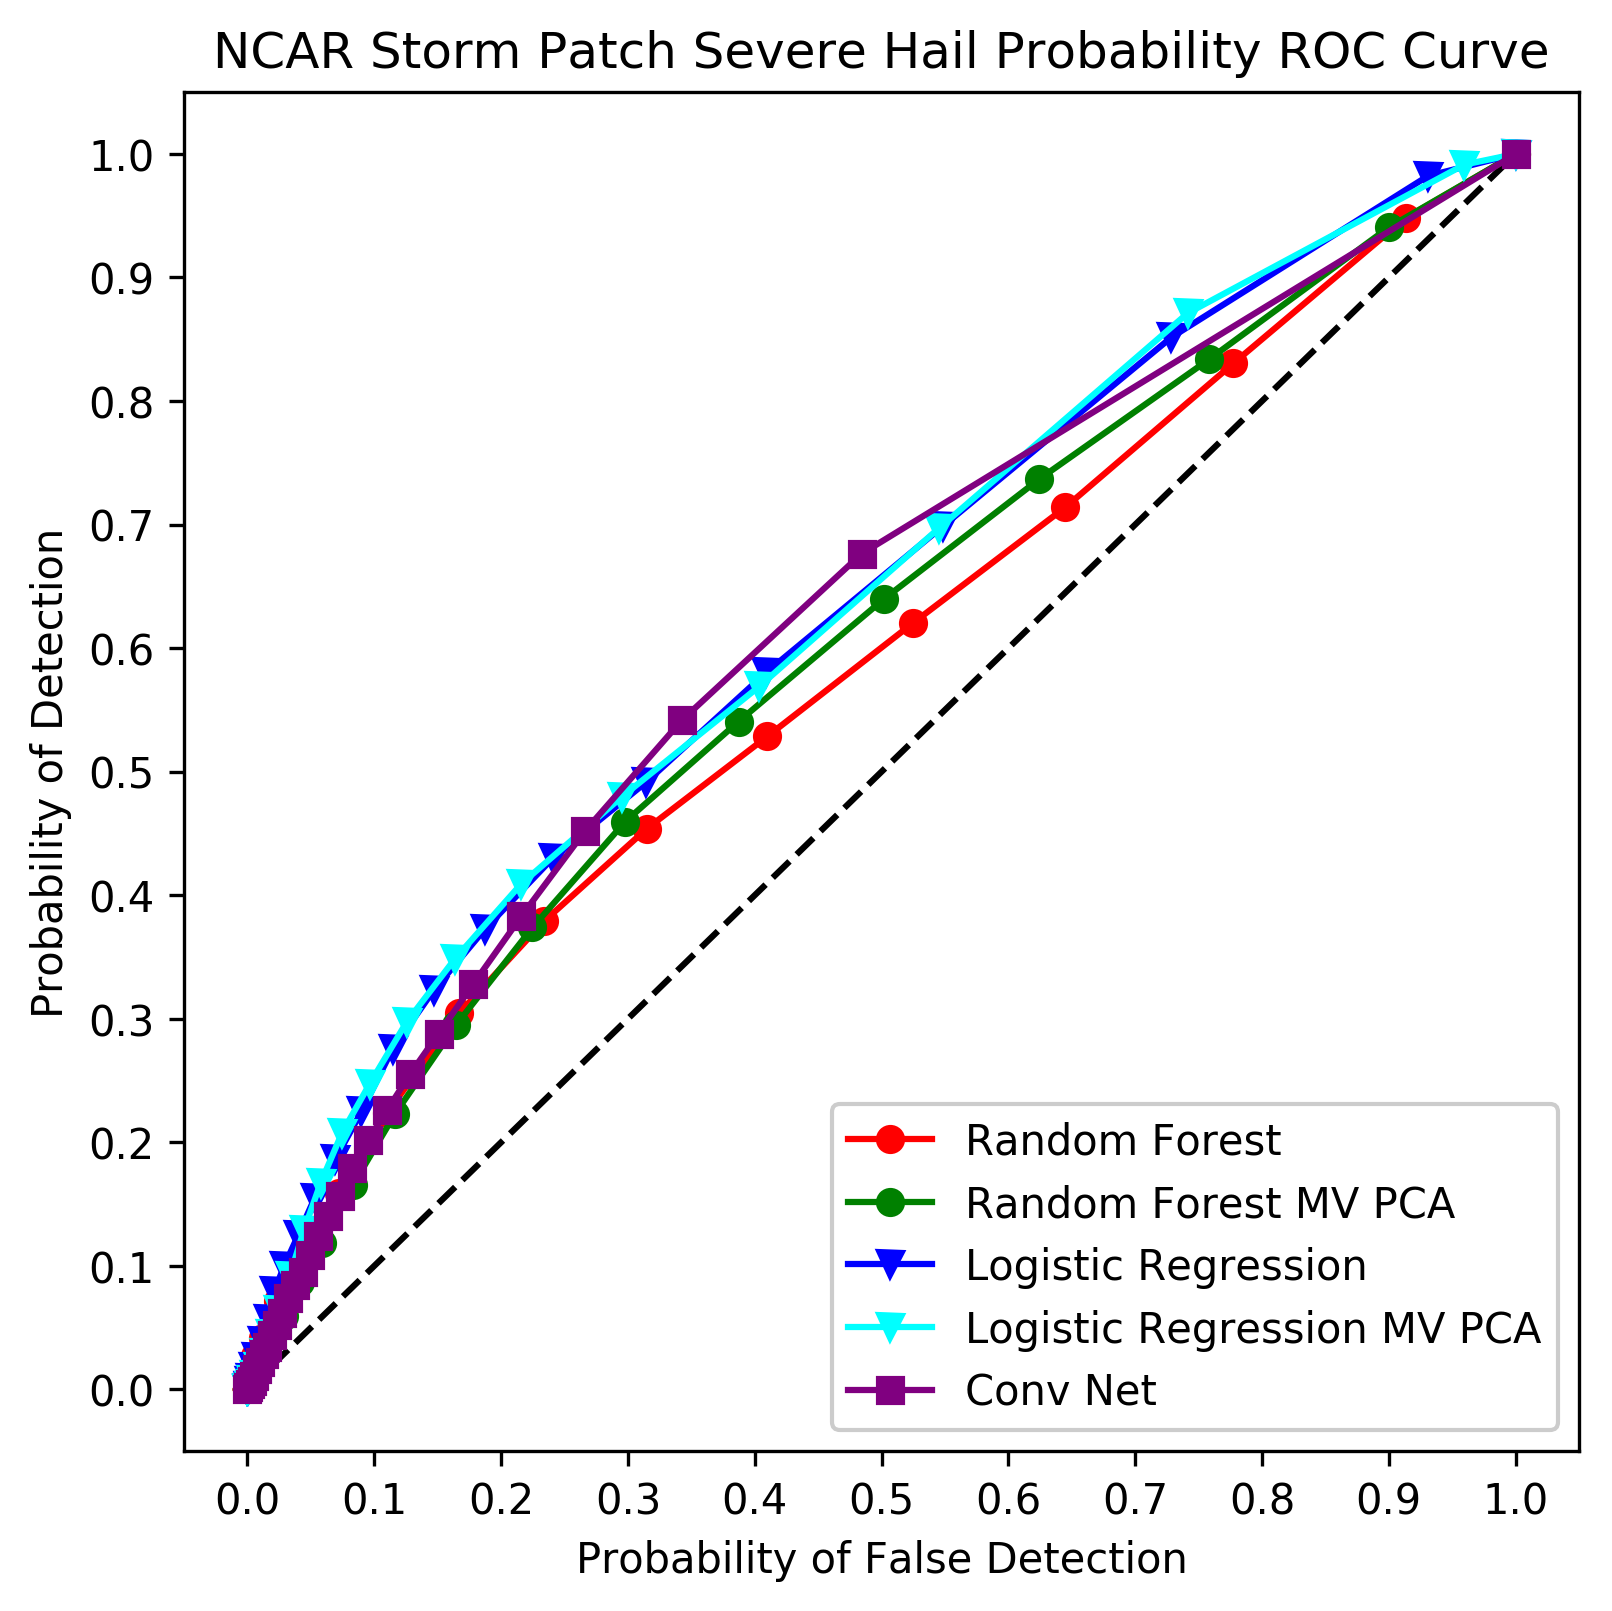

In [221]:
Image("hail_prob_roc.png", width=500)

In [222]:
pred_list = [rf_preds, rf_mv_preds, logit_preds, logit_mv_preds, cnn_preds[:, 0]]
rel_list = []
for pred in pred_list:
    rel_list.append(DistributedReliability(thresholds=thresholds))
    rel_list[-1].update(pred, test_labels)
print([rel.brier_skill_score() for rel in rel_list])

[-0.012856043167797154, -0.017923470700227595, 0.0079784492069563083, 0.011426619526118906, -0.10631672454167339]


In [223]:
attributes_diagram(rel_list, ml_model_names,
                   ml_model_colors, ml_model_symbols, "hail_prob_rel.png", figsize=(6, 6), 
                      title="NCAR Storm Patch Severe Hail Probability Reliability")

/scratch/dgagne/miniconda3/envs/deep/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


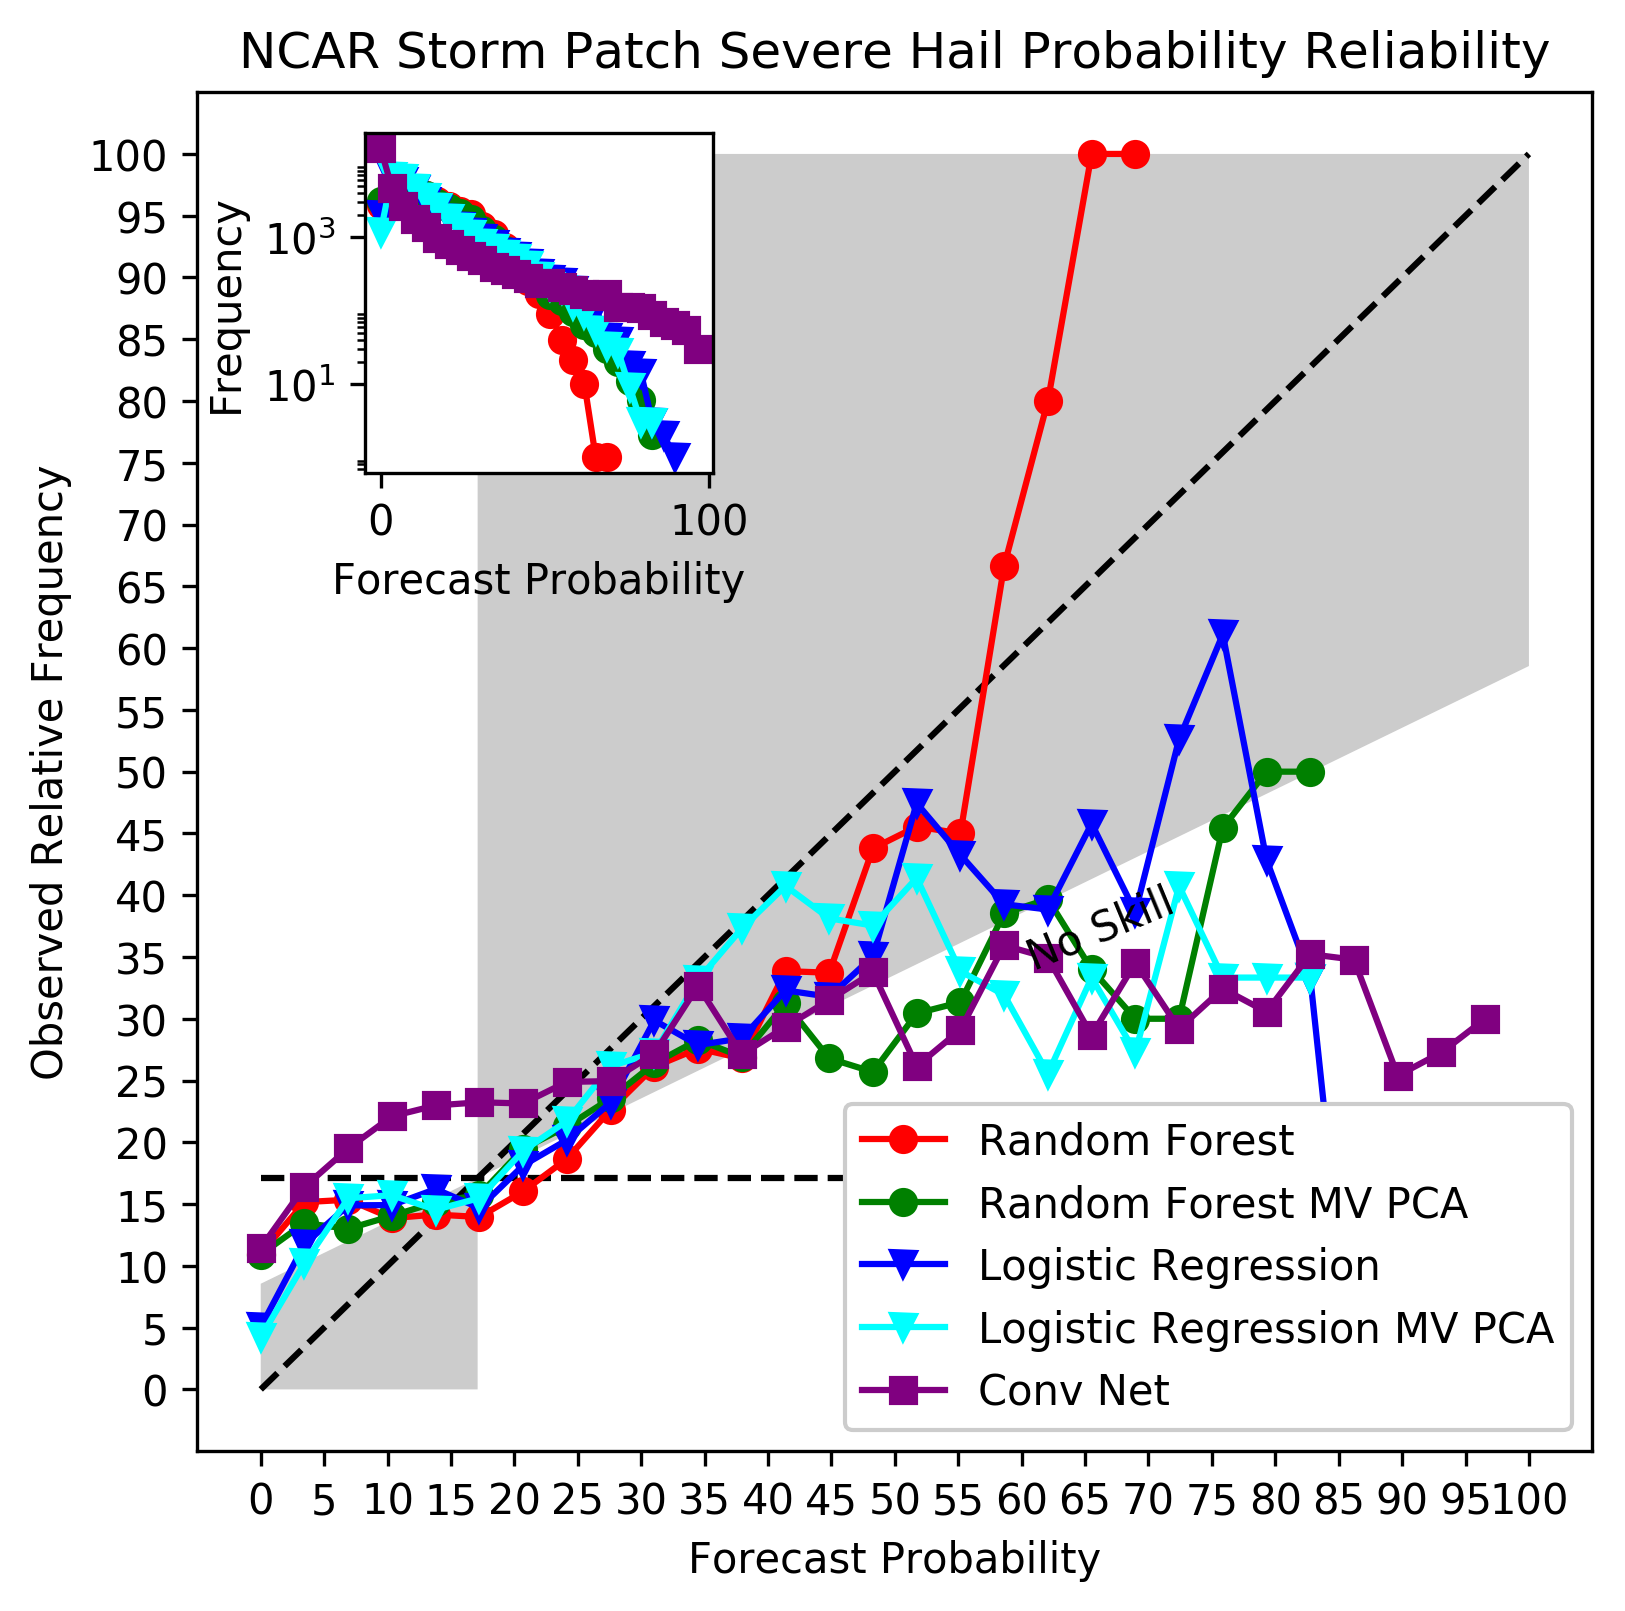

In [224]:
Image("hail_prob_rel.png")

In [218]:
i = 0
for f in range(5):
    for g in range(10):
        print(f, g, rf.feature_importances_[i])
        i += 1

0 0 0.029769374336
0 1 0.0229218584807
0 2 0.0191819303443
0 3 0.0190074045799
0 4 0.0190764015707
0 5 0.0191413043682
0 6 0.0163397488766
0 7 0.0155629552912
0 8 0.0168175598434
0 9 0.0172433324248
1 0 0.0598858619782
1 1 0.0234900844755
1 2 0.0191107043866
1 3 0.017886477526
1 4 0.0169378463512
1 5 0.0193700432037
1 6 0.0178497173052
1 7 0.0152138667484
1 8 0.0164690165982
1 9 0.0161628491396
2 0 0.0459985792386
2 1 0.024606694678
2 2 0.0219315511601
2 3 0.0170269901808
2 4 0.0172493274035
2 5 0.0156226568298
2 6 0.0163031027463
2 7 0.0154156165846
2 8 0.0171270198752
2 9 0.015992684139
3 0 0.0499961019237
3 1 0.0184632567262
3 2 0.0217224133615
3 3 0.0173440765339
3 4 0.0162468282906
3 5 0.0148681474963
3 6 0.0148607349219
3 7 0.0153848752411
3 8 0.0153677381097
3 9 0.0145026925945
4 0 0.0247942555725
4 1 0.0198102811841
4 2 0.0209330207186
4 3 0.0171594549657
4 4 0.0197112242473
4 5 0.0154211186883
4 6 0.0145522567509
4 7 0.0152190225191
4 8 0.0146746689796
4 9 0.0142552705102


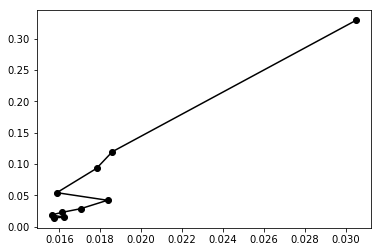

In [81]:
plt.plot(rf.feature_importances_[:10], pc_objs[1].explained_variance_ratio_, 'ko-')

In [83]:
pc_objs[0].explained_variance_ratio_

array([ 0.32953609,  0.11959258,  0.09301332,  0.05424811,  0.04212579,
        0.02868085,  0.02267651,  0.01879894,  0.01506675,  0.01394645])

In [177]:
def hail_patch_model(input_size=(64, 64, 6), filter_width=5, min_data_width=4,
                    min_conv_filters=64, stride=2):
    """
    Creates an encoder convolutional neural network that reproduces the generator input vector. The keyword arguments
    allow aspects of the structure of the generator to be tuned for optimal performance.

    Args:
        input_size (tuple of ints): Number of nodes in the input layer.
        filter_width (int): Width of each convolutional filter
        min_data_width (int): Width of the last convolved layer
        min_conv_filters (int): Number of convolutional filters in the first convolutional layer
        output_size (int): Dimensions of the output
        stride (int): Number of pixels that the convolution filter shifts between operations.

    Returns:
        Keras convolutional neural network.
    """
    num_layers = int(np.log2(input_size[0]) - np.log2(min_data_width))
    curr_conv_filters = min_conv_filters
    image_input = Input(shape=input_size, name="patch_input")
    model = None
    for c in range(num_layers):
        if c == 0:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same",
                           kernel_regularizer=l2())(image_input)
        else:
            model = Conv2D(curr_conv_filters, filter_width,
                           strides=(stride, stride), padding="same",
                           kernel_regularizer=l2())(model)
        model = BatchNormalization()(model)
        model = Activation("relu")(model)
        curr_conv_filters *= 2
    model = Flatten()(model)
    model = Dense(1, kernel_regularizer=l2())(model)
    model = Activation("sigmoid")(model)
    return model, image_input

In [137]:
storm_norm_data = np.zeros(storm_data.shape)
for i in range(num_vars):
    storm_norm_data[:, :, :, i] = (storm_data[:, :, :, i] - means[i]) / sds[i]

In [189]:
hail_cnn, hail_cnn_input = hail_patch_model(min_conv_filters=16)
hail_cnn_model = Model(hail_cnn_input, hail_cnn)
hail_cnn_model.compile(optimizer=Adam(lr=0.0001, beta_1=0.5), loss="mse")

In [217]:
hail_cnn_model.fit(storm_norm_data[train_indices], train_labels, batch_size=256, validation_split=0.2, epochs=5)

Train on 63416 samples, validate on 15854 samples
Epoch 1/5
63416/63416 [==============================] - 57s - loss: 0.1187 - val_loss: 0.1557

In [218]:
cnn_preds = hail_cnn_model.predict(storm_norm_data[test_indices])

(array([ 20022.,   4576.,   2743.,   1906.,   1435.,   1082.,    864.,
           622.,    419.,    173.]),
 array([  4.15693758e-05,   9.90079568e-02,   1.97974344e-01,
          2.96940732e-01,   3.95907119e-01,   4.94873506e-01,
          5.93839894e-01,   6.92806281e-01,   7.91772669e-01,
          8.90739056e-01,   9.89705443e-01]),
 <a list of 10 Patch objects>)

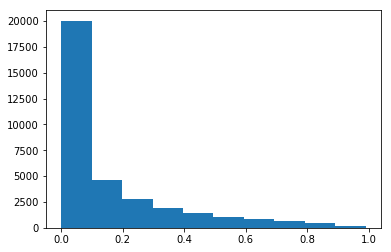

In [199]:
plt.hist(cnn_preds[:, 0])

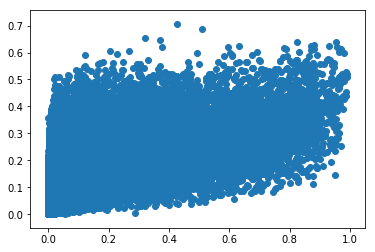

In [201]:
plt.scatter(cnn_preds[:, 0], rf_preds)

In [225]:
hail_cnn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
patch_input (InputLayer)     (None, 64, 64, 6)         0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 16)        2416      
_________________________________________________________________
batch_normalization_25 (Batc (None, 32, 32, 16)        64        
_________________________________________________________________
activation_55 (Activation)   (None, 32, 32, 16)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 32)        12832     
_________________________________________________________________
batch_normalization_26 (Batc (None, 16, 16, 32)        128       
_________________________________________________________________
activation_56 (Activation)   (None, 16, 16, 32)        0         
__________

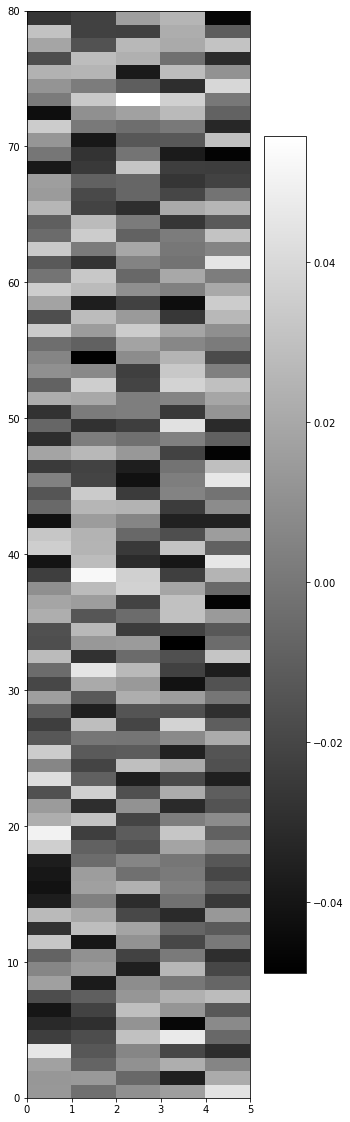

In [297]:
plt.figure(figsize=(5, 20))
plt.pcolormesh(hail_cnn_model.layers[1].get_weights()[0][:, :, 0].reshape(80, 5), cmap="gray")
plt.colorbar()

In [271]:
sys.getsizeof(storm_data) / 2**30

(5, 5, 6, 16)

In [288]:
hail_cnn_model.layers[1].get_weights()[0][:, :, 0].shape

(5, 5, 16)

In [293]:
400 / 5

80.0

In [260]:
hail_cnn_model.save("/scratch/dgagne/hail_models/hail_cnn.h5")